In [1]:
# 定义标签映射
label_map = {
    0: 'disgust',
    1: 'happiness',
    2: 'others',
    3: 'repression',
    4: 'surprise'
}

In [2]:
from PIL import Image
import numpy as np
import os

# 数据集路径
dataset_path = 'D:/casme2_yolo'

# 图像尺寸和类别数量
img_height, img_width = 128, 128
num_classes = 5

# 表情标签
emotions = ['disgust', 'happiness', 'others', 'repression', 'surprise']

# 初始化X和y
X = []
y = []

# 遍历每个表情类别
for label, emotion in enumerate(emotions):
    emotion_path = os.path.join(dataset_path, emotion)
    
    # 遍历表情文件夹中的所有子文件夹
    for subfolder in os.listdir(emotion_path):
        subfolder_path = os.path.join(emotion_path, subfolder)
        
        # 遍历子文件夹中的所有图像文件
        for img_file in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, img_file)
            
            # 加载图像
            img = Image.open(img_path)  # 确保图像为RGB格式
            img = img.convert('L')  # 将图像转换为灰度
            img = img.resize((img_width, img_height))  # 调整图像大小
            img = np.array(img)
            if len(img.shape) == 2:
                img = np.expand_dims(img, axis=-1)
            # 将图像和标签添加到列表中
            X.append(img)
            y.append(label)

# 将列表转换为numpy数组
X = np.array(X)
y = np.array(y)

# 归一化图像数据
X = X / 255.0



In [3]:
X.shape,y.shape

((16723, 128, 128, 1), (16723,))

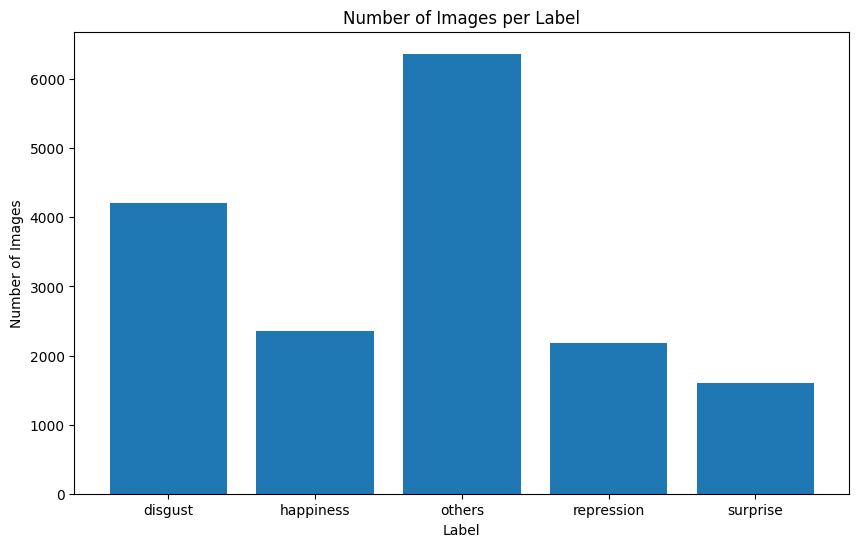

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# 计算每个标签的图像数量
label_counts = np.bincount(y)

# 创建标签名称（如果你有标签名称的话，否则可以使用数字）
labels = [label_map[i] for i in range(num_classes)]

# 创建柱状图
plt.figure(figsize=(10, 6))
plt.bar(labels, label_counts)

# 添加标题和标签
plt.title('Number of Images per Label')
plt.xlabel('Label')
plt.ylabel('Number of Images')

# 显示图表
plt.show()


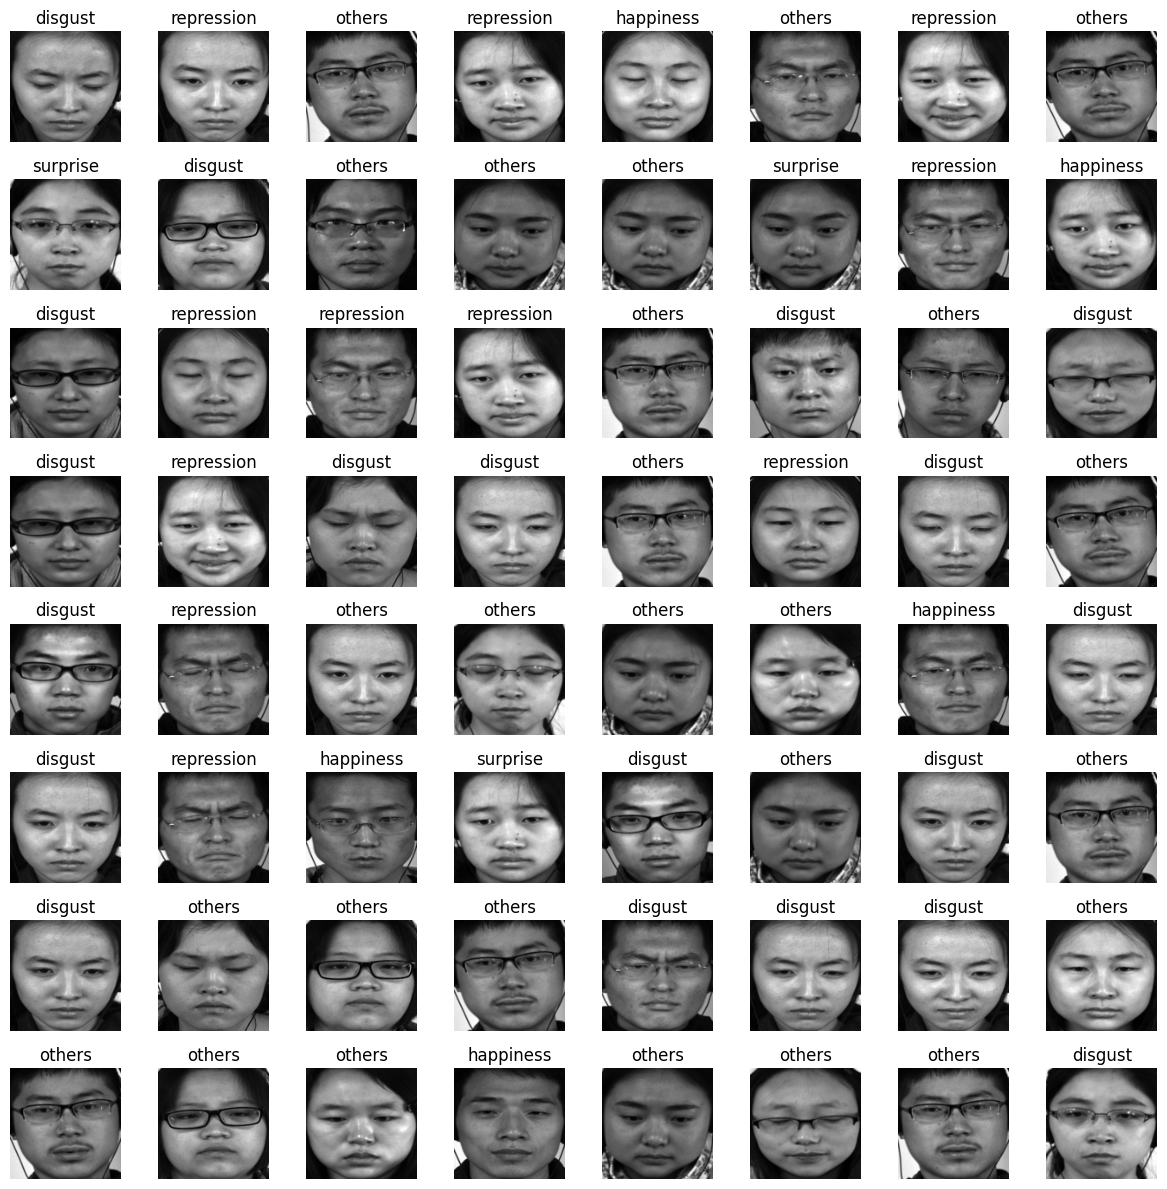

In [5]:
# import matplotlib.pyplot as plt
# import random

# # 随机选择64张图片
# num_images = 64
# random_indices = random.sample(range(len(X)), num_images)
# selected_images = X[random_indices]
# selected_labels = y[random_indices]

# # 创建一个8x8的图像网格
# plt.figure(figsize=(10, 10))
# for i in range(num_images):
#     plt.subplot(8, 8, i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     plt.imshow(selected_images[i], cmap=plt.cm.binary)
#     plt.xlabel(selected_labels[i])
# plt.show()

import matplotlib.pyplot as plt
from random import sample

# 随机选择64张图片
sample_indices = sample(range(len(X)), 64)
sample_images = [X[i] for i in sample_indices]
sample_labels = [y[i] for i in sample_indices]

# 创建画布
fig, axes = plt.subplots(8, 8, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    # 显示图片
    if sample_images[i].shape[2] == 1:  # 灰度图
        ax.imshow(sample_images[i].reshape(img_height, img_width), cmap='gray')
    else:  # 彩色图
        ax.imshow(sample_images[i])
    
    # 显示标签
    ax.set_title(label_map[sample_labels[i]])
    # 隐藏坐标轴
    ax.axis('off')

# 调整布局
plt.tight_layout()
plt.show()


## 图像增强

In [6]:
from keras.preprocessing.image import ImageDataGenerator

# 创建图像数据生成器实例
datagen = ImageDataGenerator(
    # 将图像随机旋转最多10度
    rotation_range=15,
    # 将图像随机缩放10%以内
    zoom_range = 0.1,
    # width_shift_range = 0.1,
    # height_shift_range= 0.1,
    # 以50%概率对图像进行水平翻转
    horizontal_flip=True,
    featurewise_center=False)



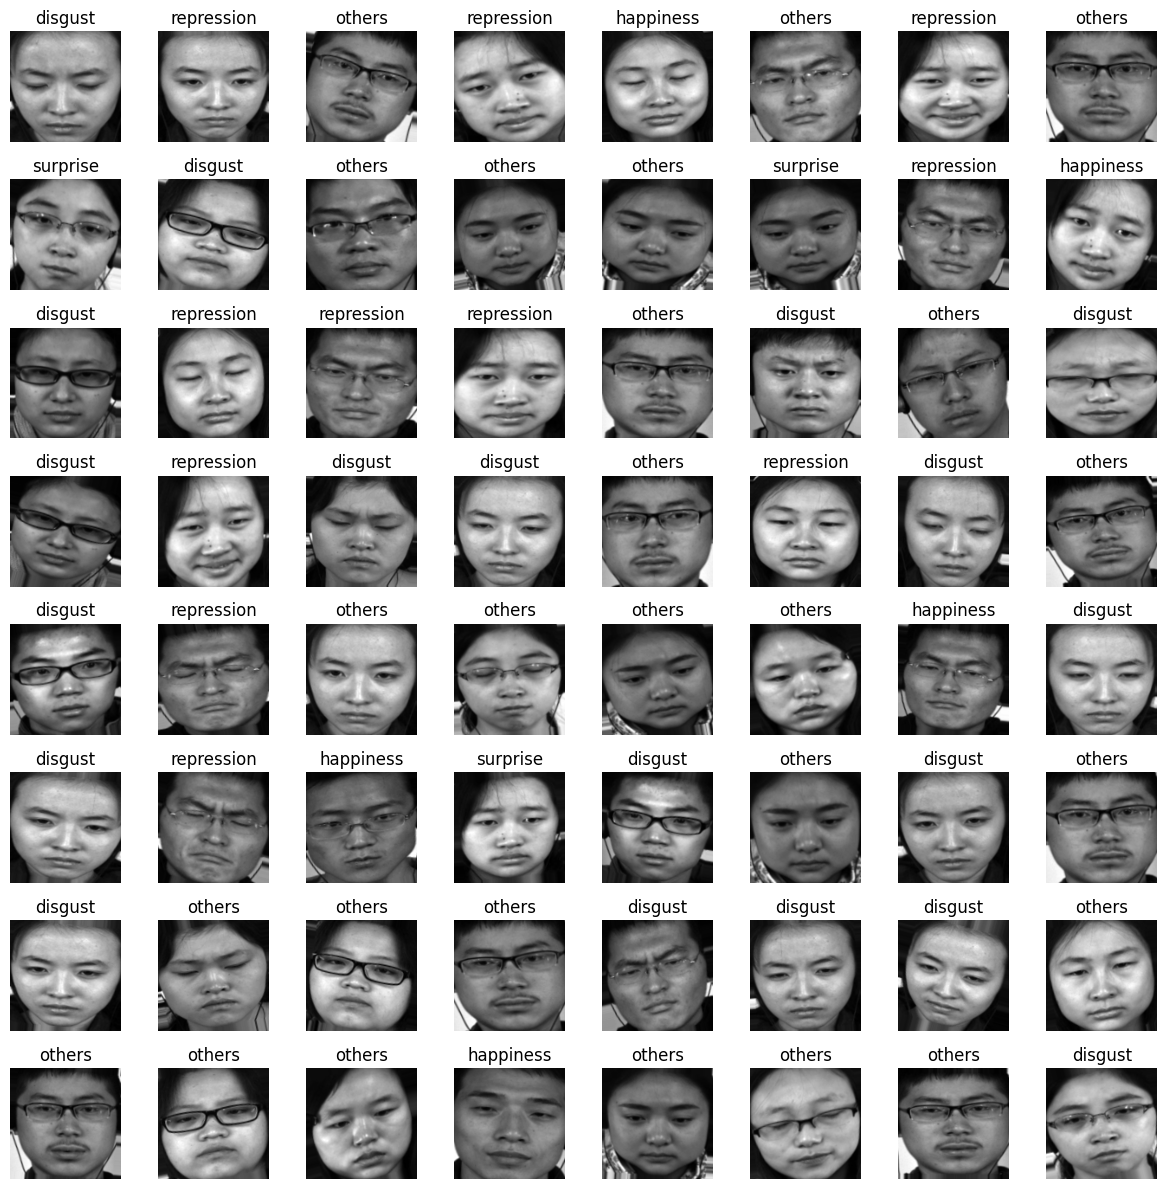

In [7]:
# 查看增强后的图像
# sample_indices = sample(range(len(X)), 64)
# sample_images = [X[i] for i in sample_indices]
# sample_labels = [y[i] for i in sample_indices]

# 创建画布
fig, axes = plt.subplots(8, 8, figsize=(12, 12))

# 生成并显示增强后的图像
for i, ax in enumerate(axes.flat):
    
    # 将图像转换为形状为 (1, height, width, channels) 的数组
    img_array = np.expand_dims(sample_images[i], axis=0)

    # 使用flow方法生成增强后的图像
    augmented_img = datagen.flow(img_array, batch_size=1)[0][0]
    
    # 显示增强后的图像
    ax.imshow(augmented_img[:, :, 0], cmap='gray')
    ax.set_title(label_map[sample_labels[i]])
    ax.axis('off')

# 调整布局
plt.tight_layout()
plt.show()

## 建立模型

In [8]:
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, ReLU, Dense, GlobalAveragePooling2D, Reshape, multiply, Add, Flatten, Dropout
from keras.models import Model


def CNNModel(input_shape=(128, 128, 1), classes=5):

    img_input = Input(shape=input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(img_input)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 2 
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 3 
    x = Conv2D(256, (5, 5), activation='relu', padding='same')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    

    # 完成网络其余部分
    x = Flatten()(x)
    x = Dense(256, activation='relu', name='fc2')(x)
    x = Dropout(0.5)(x)
    x = Dense(classes, activation='softmax')(x)

    model = Model(img_input, x, name='cnn_model')
    return model



In [9]:
# 创建模型实例
model = CNNModel()
model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 256)       81

In [10]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

# 转换成独热编码
one_hot = to_categorical(y, num_classes)
y = np.stack(one_hot)

# 划分数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# 计算特征归一化所需的数量
datagen.fit(X_train)


X_train shape: (13378, 128, 128, 1)
y_train shape: (13378, 5)
X_test shape: (3345, 128, 128, 1)
y_test shape: (3345, 5)


In [11]:
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# 初始化 Adam 优化器并设置初始学习率
initial_learning_rate = 0.0001
optimizer = Adam(learning_rate=initial_learning_rate)

# 编译模型
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# 设置 ReduceLROnPlateau 回调函数
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_lr=1e-10)
# 设置 EarlyStopping 回调函数
early_stopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)


# 定义训练周期和批次大小
epochs = 30  # 可以根据需要调整
batch_size = 32  # 可以根据硬件条件调整

# 训练模型
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=epochs, validation_data=(X_test, y_test), callbacks=[lr_reducer, early_stopper])
# history = model.fit(
#     train_generator, 
#     steps_per_epoch=train_generator.samples // train_generator.batch_size, 
#     epochs=epochs, 
#     validation_data=validation_generator,
#     validation_steps=validation_generator.samples // validation_generator.batch_size,
#     callbacks=[lr_reducer])



Epoch 1/30
419/419 [==============================] - 81s 134ms/step - loss: 1.2995 - accuracy: 0.4356 - val_loss: 1.1851 - val_accuracy: 0.4933 - lr: 1.0000e-04
Epoch 2/30
419/419 [==============================] - 52s 123ms/step - loss: 1.0716 - accuracy: 0.5267 - val_loss: 1.0048 - val_accuracy: 0.6299 - lr: 1.0000e-04
Epoch 3/30
419/419 [==============================] - 52s 123ms/step - loss: 0.9129 - accuracy: 0.6058 - val_loss: 0.8174 - val_accuracy: 0.6750 - lr: 1.0000e-04
Epoch 4/30
419/419 [==============================] - 52s 123ms/step - loss: 0.7707 - accuracy: 0.6705 - val_loss: 0.7113 - val_accuracy: 0.7196 - lr: 1.0000e-04
Epoch 5/30
419/419 [==============================] - 52s 123ms/step - loss: 0.6503 - accuracy: 0.7225 - val_loss: 0.5348 - val_accuracy: 0.8182 - lr: 1.0000e-04
Epoch 6/30
419/419 [==============================] - 51s 122ms/step - loss: 0.5773 - accuracy: 0.7550 - val_loss: 0.6324 - val_accuracy: 0.7351 - lr: 1.0000e-04
Epoch 7/30
419/419 [========

105/105 [==============================] - 4s 40ms/step


(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0, 0.5, 'disgust'),
  Text(0, 1.5, 'happiness'),
  Text(0, 2.5, 'others'),
  Text(0, 3.5, 'repression'),
  Text(0, 4.5, 'surprise')])

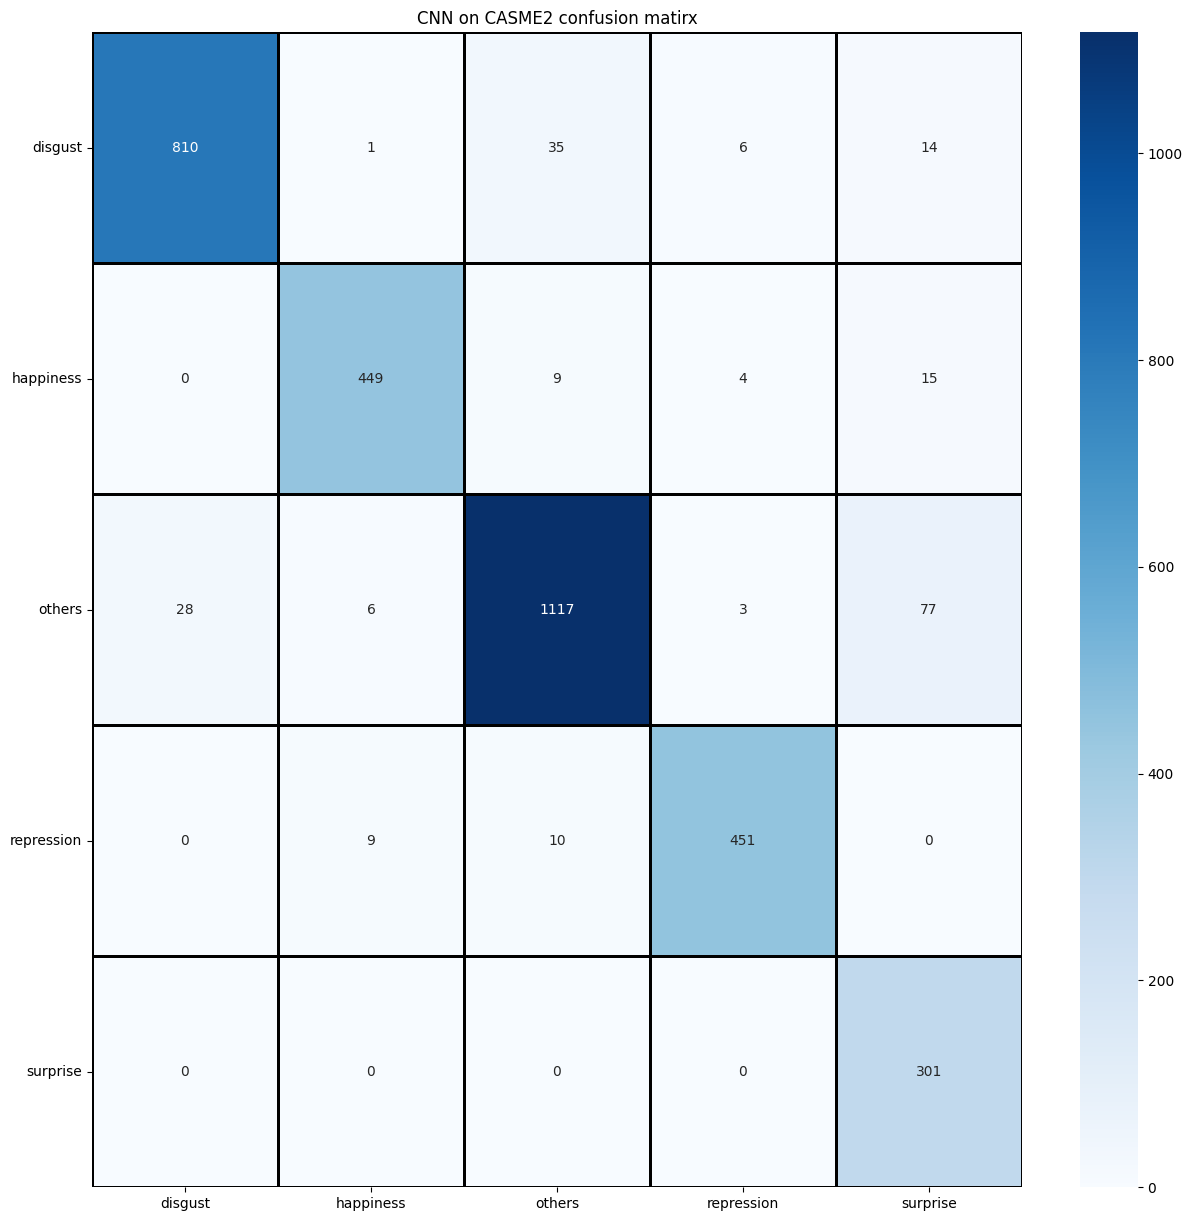

In [12]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from keras.models import load_model
# model = load_model('D:/大学文件/毕业设计/毕设src/face_rec1_30epochs.h5')
# 混淆矩阵可视化
y_pred=model.predict(X_test) 
classes_y=np.argmax(y_pred,axis=1)
y_true_class = np.argmax(y_test, axis=1) 
dfConfMat = pd.DataFrame(confusion_matrix(y_true_class,classes_y), index = [label_map[i] for i in range(len(label_map))],
                     columns = [label_map[i] for i in range(len(label_map))])
plt.figure(figsize = (15,15))
plt.title("CNN on CASME2 confusion matirx")
sns.heatmap(dfConfMat,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')
# 设置y轴字体正置
plt.yticks(rotation=0)

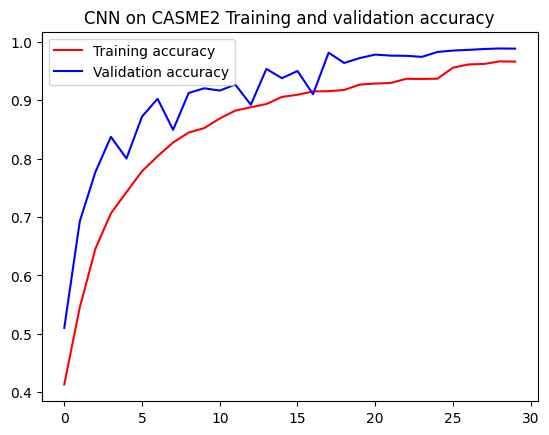

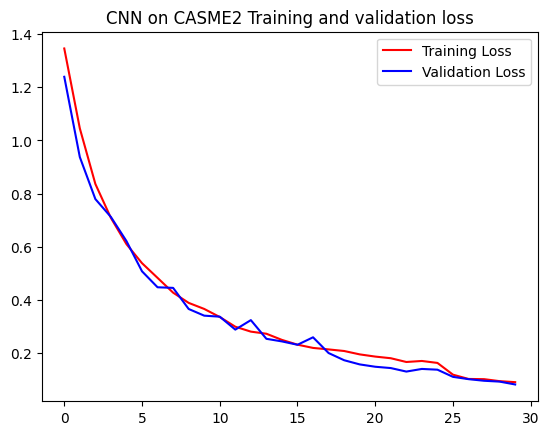

In [13]:
# 获取准确率与损失函数情况
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# matplotlib绘制训练过程中指标的变化状况
epochs = range(len(acc))

import matplotlib.pyplot as plt
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('CNN on CASME2 Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('CNN on CASME2 Training and validation loss')
plt.legend()

plt.show()

In [14]:
# import cv2
# import matplotlib.pyplot as plt
# # img = cv2.imread('../data-1/disgust/EP01_01/reg_img111.jpg')
# # img = cv2.imread('../data-1/fear/EP13_01/reg_img35.jpg')
# # img = cv2.imread('../data-1/fear/EP13_02/reg_img72.jpg')
# # img = cv2.imread('../data-1/sadness/EP10_03/reg_img357.jpg')
# # img = cv2.imread('../data-1/sadness/EP15_03/reg_img321.jpg')
# img = cv2.imread('../data-1/surprise/EP01_13/reg_img92.jpg')
# test_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# plt.imshow(test_img)
# img = cv2.resize(img, (224,224))
# img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# img_gray = img_gray / 255.0
# gray = img_gray[:,:,np.newaxis]
# # gray.shape
# gray = np.expand_dims(gray, axis=0) 
# prd = model.predict(gray)
# print(prd)
# prediction = label_map[np.argmax(prd)]
# prediction

In [13]:
model.save('models/cnn_casme2_0330_1945ACC93.h5')